# COP 26 Temperature analysis 

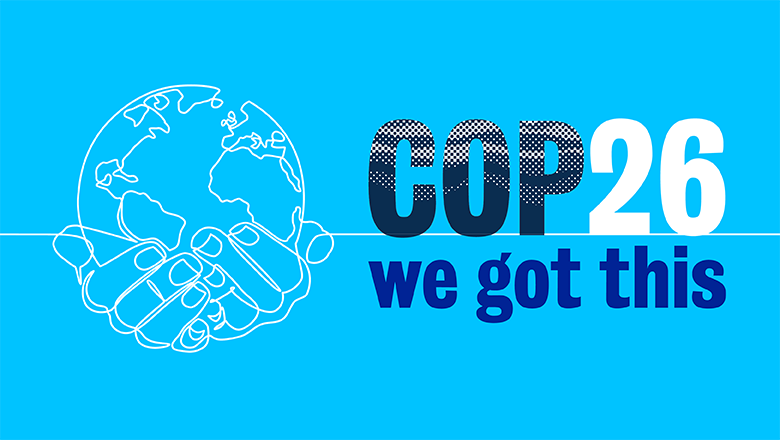

#### For the first time ever, something momentous happened: every country agreed to work together to limit global warming to well below 2 degrees and aim for 1.5 degrees, to adapt to the impacts of a changing climate and to make money available to deliver on these aims. 

# By
Prasanth Dwadasi

## Objective of the Notebook

1. In which year the temperature will cross the 1.5$^\circ$celsius <br>
2. How Temperature is effected by Co2 <br>
3. Predicting Future Fossil fuel and CO2 Emission <br>

# Importing Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import traceback
import logging
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from statsmodels.tsa.vector_ar.var_model import VAR
# from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Forecasting Temperature
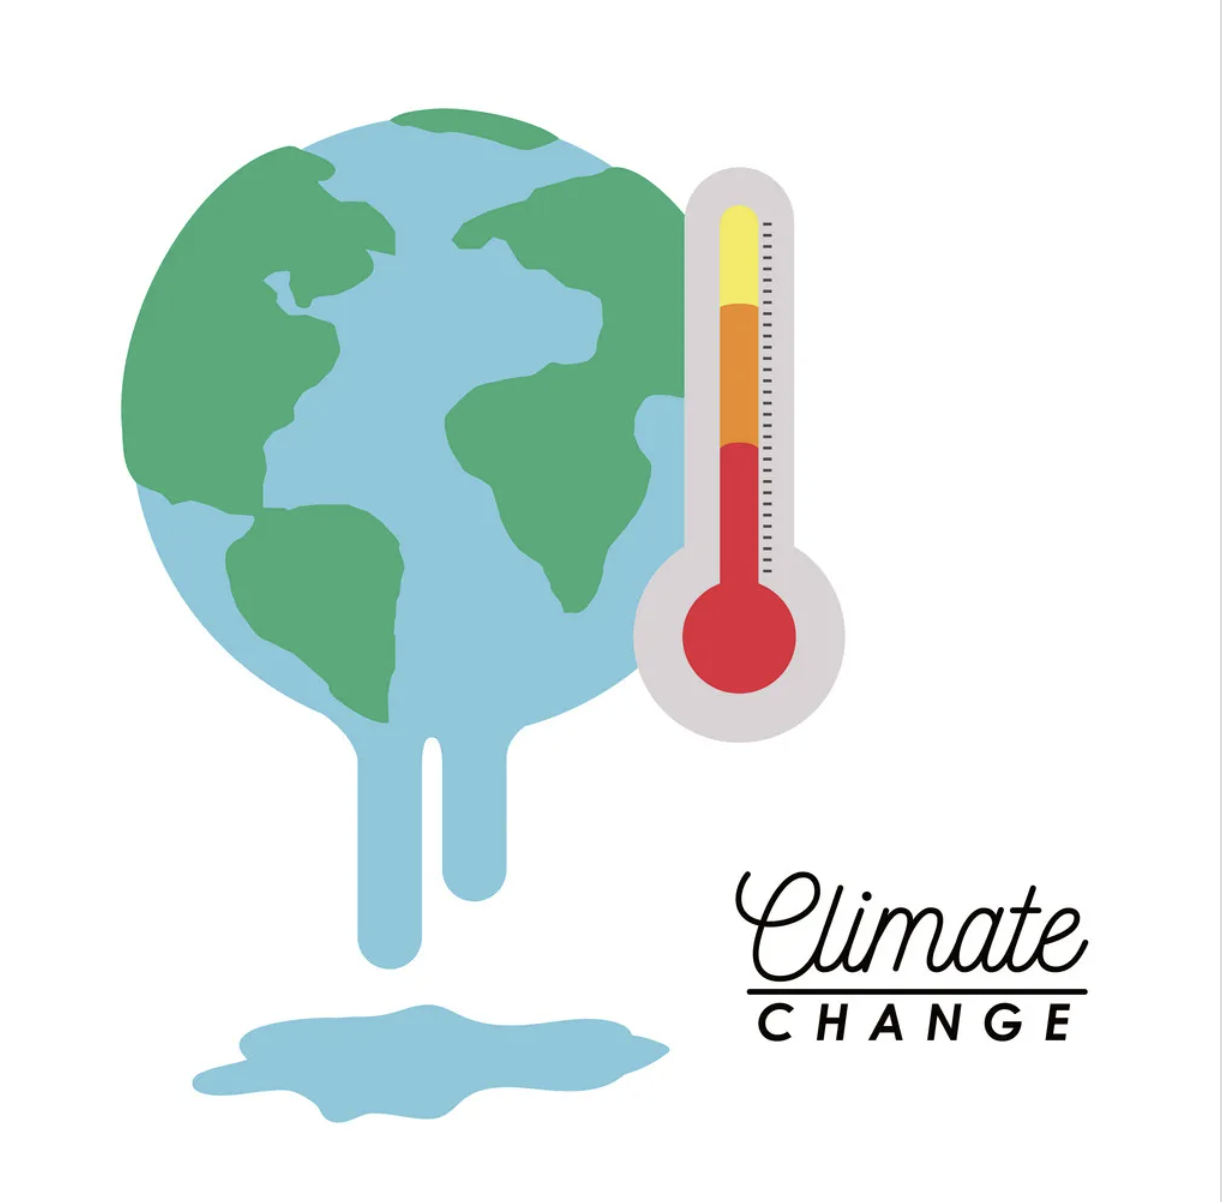

### Reading the Data

In [2]:
temperature = pd.read_csv("data/global_temp.csv")
temperature

,Year,Temperature
0,1850,-0.438
1,1851,-0.324
2,1852,-0.297
3,1853,-0.295
4,1854,-0.293
...,...,...
166,2016,1.059
167,2017,0.963
168,2018,0.888
169,2019,1.025


### Setting the index in Datetime format

In [3]:
temperature.index = pd.to_datetime(temperature['Year'],format='%Y')
temperature.index = pd.DatetimeIndex(temperature.index).year
temperature = temperature.drop(columns = ['Year'])
temperature.head(10)

,Temperature
Year,
1850,-0.438
1851,-0.324
1852,-0.297
1853,-0.295
1854,-0.293
1855,-0.282
1856,-0.398
1857,-0.538
1858,-0.332


Text(0.5, 1.0, 'Temperature across years')

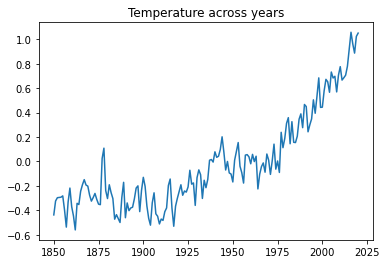

In [4]:
plt.plot(temperature)
plt.title("Temperature across years")

Text(0.5, 1.0, 'Frequency')

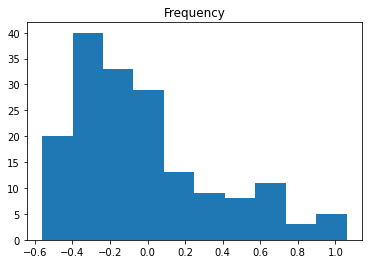

In [5]:
plt.hist(temperature)
plt.title("Frequency")

### From the above plots it is descernible that data is not stationery

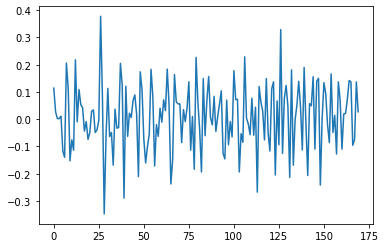

In [6]:
#As data is not stationery we are checking if first difference make it stationery
diff = np.diff(temperature.Temperature)
plt.plot(diff)

In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

In [7]:
# Performing ADF (Augmented Dicky Fuller test) to check whether the data is stationery 
X = diff
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.913210
p-value: 0.000000


Lower the p value and ADF Statistic tells that the Time serises is Stationery. And looking at the results we got in above cell we can say that the time series is stationery.

# Getting the p,q value for ARIMA model

***Autoregressive Integrated Moving Average Model***

An ARIMA model is a class of statistical models for analyzing and forecasting time series data.

It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.
Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

**p**: The number of lag observations included in the model, also called the lag order.

**d**: The number of times that the raw observations are differenced, also called the degree of differencing.

**q**: The size of the moving average window, also called the order of moving average.

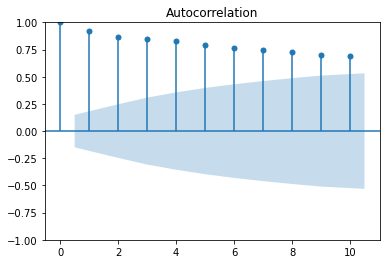

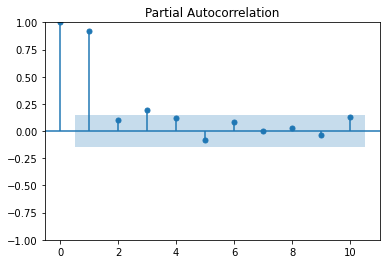

In [8]:
plot_acf(temperature,lags = 10)
plot_pacf(temperature,lags = 10,method='ywm')
plt.show()

By looking at the above **ACF and PACF plots** we can select the range of **p as 1 to 4 and q as 1 to 8** for further computation. 

## Fitting the model 
<h4>Aic and Bic </h4>
Something we want to know how good is our model explaining relartrion ship between our parameters and we can use inofrmation criteria for that. The popular criteria are AIC and BIC and we can use either.



AIC(Akaike information criterion): AIC= 2k - 2 Log(L)



L- probabilty of observing X given Thetha and M (Measure of goodness of fit)



2k increase as we increase parameters in our model (This penalise us for building models which are complicated)



2Log(L) - decrease as our model gets better in explaining our data (rewards us for building better model)



AIC helps us strike balance for models that are complex and models that are good in explaining our data.

The P value corresponds to Auto regression(P) and Q value correspionds to Moving average(Q)
We can take P from Partical auto correlation plot and Q from ACF plot but we are looping P,Q over a range
and selects the best values based on lowest AIC

In [9]:
p_range = list(range(1,4))  # taking values from 1 to 4
q_range = list(range(1,8))  # taking values from 1 to 8
aic_values = []
pq_values = []
d = 1
for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(temperature, order=(p, 1, q),enforce_stationarity=False)
            results = model.fit()
            aic_values.append(results.aic)
            pq_values.append((p, q))
        except Exception as e:
            logging.error(traceback.format_exc())


best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)

(p,q) corresponding to lowest AIC score:  (3, 2)


The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. 

**Lower the AIC value out of all other models AIC value says that is the best fit model.**

## MAE value

The MAE measures the average magnitude of the errors in a set of forecasts, without considering their direction. It measures accuracy for continuous variables.

In [10]:
arima_model = ARIMA(temperature, order=(best_pq[0], 0, best_pq[1]),enforce_stationarity=False).fit()
predictions = arima_model.predict(start=0, end=len(temperature)-1)

mae = mean_absolute_error(list(temperature.Temperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.08777319757796567


Comparing the Predicted Temperture values with the actual values.

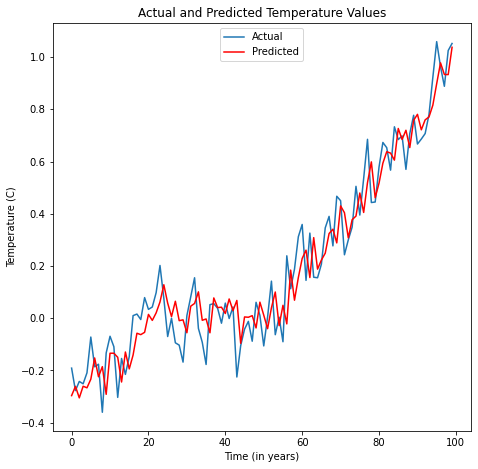

In [11]:
plt.figure(figsize=(7.5,7.5))
plt.plot(list(temperature.Temperature)[-100:], label="Actual")
plt.plot(list(predictions)[-100:], 'r', label="Predicted")

plt.xlabel("Time (in years)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center')
plt.show()

As we can see we got pretty good results.

**Now we'll predict future years temperature Data.**

In [12]:
# number_of_steps = 50
# out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)
start = 160
end = 190
out_of_sample_forecast = arima_model.predict(start = start,end=end)
date_index = pd.date_range('2010', periods=end-start+1, freq='Y')
out_of_sample_forecast.index = date_index

## Predicted temperature

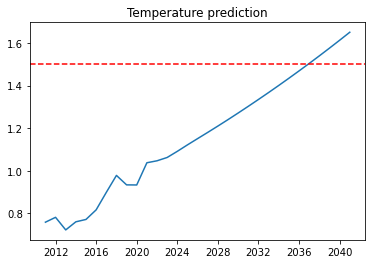

In [13]:
# out_of_sample_forecast.plot()
plt.plot(out_of_sample_forecast)
plt.title("Temperature prediction")
plt.axhline(y=1.5, color='r', linestyle='--')

By using univariate ARIMA model it is visible that the aproximate year predicted by model in which the temperature will cross 1.5 mark will be around 2035.  

## Smoothening the curve for better results

In statistics, a moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. It is also called a moving mean or rolling mean and is a type of finite impulse response filter.

A moving average is commonly used with time series data to smooth out short-term fluctuations and highlight longer-term trends or cycles. The threshold between short-term and long-term depends on the application, and the parameters of the moving average will be set accordingly. For example, it is often used in technical analysis of financial data, like stock prices, returns or trading volumes.

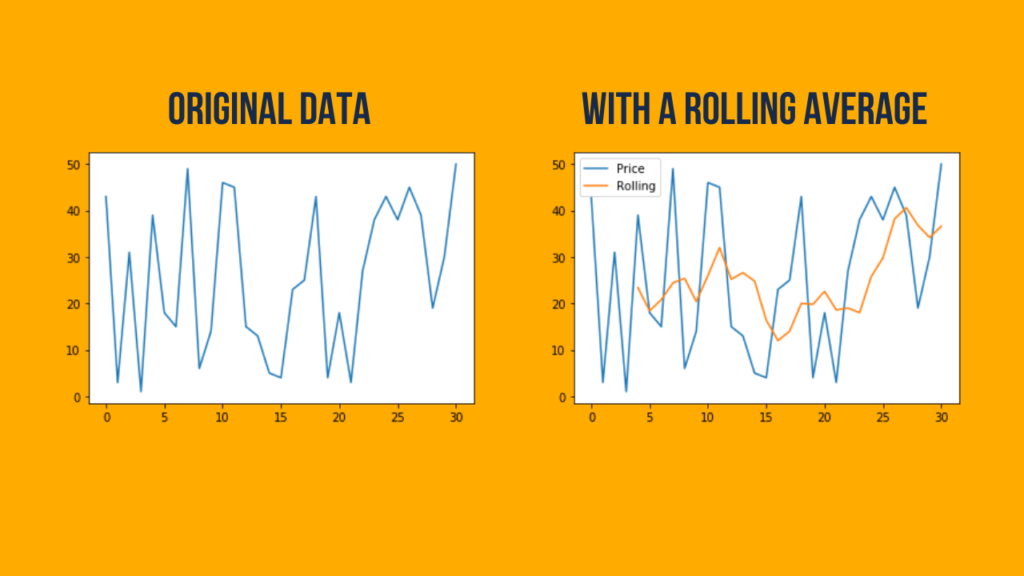

In [14]:
# A moving average is commonly used with time series data to smooth out short-term fluctuations
# and highlight longer-term trends or cycles.
window =5
rolling_mean = temperature.rolling(window=window).mean()
rolling_mean

,Temperature
Year,
1850,NaN
1851,NaN
1852,NaN
1853,NaN
1854,-0.3294
...,...
2016,0.8308
2017,0.8862
2018,0.9224


Text(0.5, 1.0, 'Smooth curved')

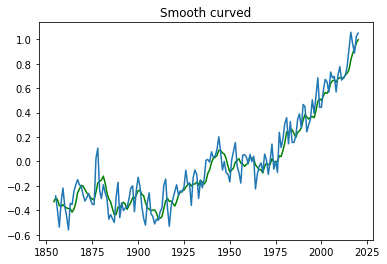

In [15]:
rolling_mean
plt.plot(rolling_mean, 'g', label='Rolling mean window ')
plt.plot(temperature[window:])
plt.title("Smooth curved")

ADF Statistic: -2.983011
p-value: 0.036512


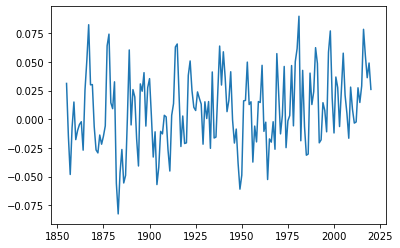

In [16]:
diff = rolling_mean.diff().dropna()
plt.plot(diff)
X = diff
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [17]:
df_smooth = rolling_mean.dropna()

## Fitting the model

In [18]:
p_range = list(range(1,4))
q_range = list(range(1,8))
aic_values = []
pq_values = []
# fitted_model_dict = {}
# count = 0
d = 1
for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(df_smooth, order=(p, d, q),enforce_stationarity=False)
            results = model.fit()
            aic_values.append(results.aic)
            pq_values.append((p, q))
        except Exception as e:
            logging.error(traceback.format_exc())


best_pq = pq_values[aic_values.index(min(aic_values))]  # (p,q) corresponding to lowest AIC score
print("(p,q) corresponding to lowest AIC score: ", best_pq)


(p,q) corresponding to lowest AIC score:  (3, 4)


## MAE Value

In [19]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

arima_model = ARIMA(df_smooth, order=(best_pq[0], 0, best_pq[1]),enforce_stationarity=False).fit()
predictions = arima_model.predict(start=0, end=len(df_smooth)-1)

mae = mean_absolute_error(list(df_smooth.Temperature), list(predictions))
print("Mean Absolute Error:", mae)

Mean Absolute Error: 0.02065544929794365


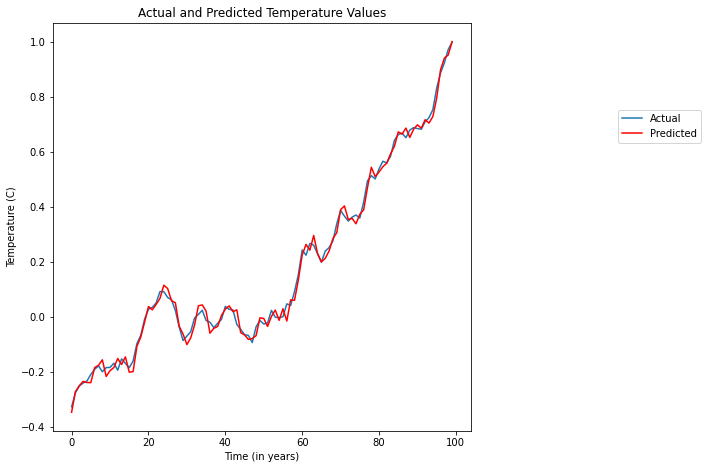

In [20]:
plt.figure(figsize=(7.5,7.5))
plt.plot(list(df_smooth.Temperature)[-100:], label="Actual")
plt.plot(list(predictions)[-100:], 'r', label="Predicted")

plt.xlabel("Time (in years)")
plt.ylabel("Temperature (C)")
plt.title("Actual and Predicted Temperature Values")

plt.legend(loc='upper center', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [21]:
# number_of_steps = 50
# out_of_sample_forecast = arima_model.forecast(steps=number_of_steps)
start = 160
end = 250
out_of_sample_forecast = arima_model.predict(start = start,end=end)
date_index = pd.date_range('2010', periods=end-start+1, freq='Y')
out_of_sample_forecast.index = date_index

## Future temperature prediction

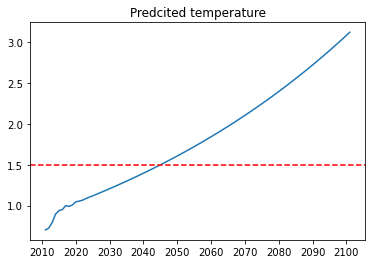

In [22]:
# out_of_sample_forecast.plot()
plt.plot(out_of_sample_forecast)
plt.title("Predcited temperature")
plt.axhline(y=1.5, color='r', linestyle='--')

#### To improve the model we smoothened the Data and applied ARIMA again and we got the above results.

# 2. Modelling Temperture based on Co2

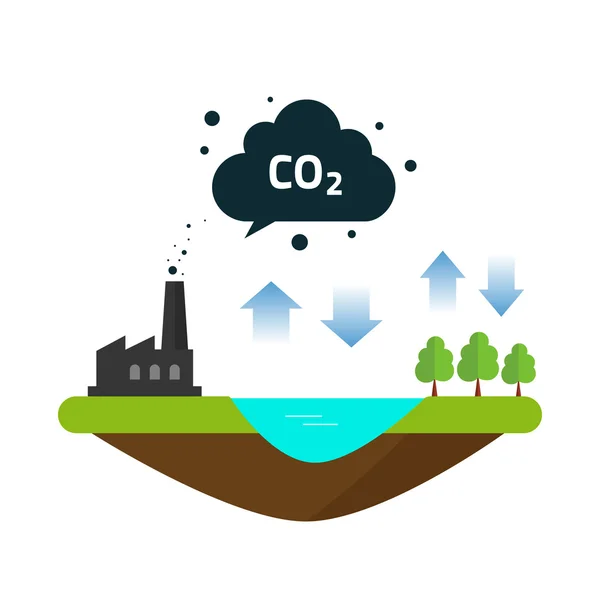

## Reading the data

In [23]:
fossil_land_c02_emissions = pd.read_csv("data/global-co2-fossil-plus-land-use.csv")
fossil_land_c02_emissions.index = pd.to_datetime(fossil_land_c02_emissions['Year'],format='%Y')
fossil_land_c02_emissions.index = pd.DatetimeIndex(fossil_land_c02_emissions.index).year
fossil_land_c02_emissions = fossil_land_c02_emissions.drop(columns = ['Year'])
fossil_land_c02_emissions

,Entity,Code,Fossil fuel + land use emissions (GtCO2),Land use emissions (GtCO2),Fossil fuel and industry emissions (GtCO2)
Year,,,,,
1850,World,OWID_WRL,2.734430e+09,2.537534e+09,1.968960e+08
1851,World,OWID_WRL,2.813746e+09,2.614941e+09,1.988050e+08
1852,World,OWID_WRL,2.861829e+09,2.654278e+09,2.075509e+08
1853,World,OWID_WRL,2.920302e+09,2.703093e+09,2.172092e+08
1854,World,OWID_WRL,2.985473e+09,2.730334e+09,2.551390e+08
...,...,...,...,...,...
2016,World,OWID_WRL,3.915603e+10,3.703575e+09,3.545246e+10
2017,World,OWID_WRL,3.958862e+10,3.662879e+09,3.592574e+10
2018,World,OWID_WRL,4.050368e+10,3.857539e+09,3.664614e+10


### Merging the two datasets 

In [24]:
temperature_c02_emissions = pd.concat([fossil_land_c02_emissions, temperature],axis=1)
temperature_c02_emissions.drop(columns=['Code','Entity'],inplace=True)
temperature_c02_emissions.rename(columns={'Fossil fuel + land use emissions (GtCO2)': 'Fossil_fuel_+_land_use_emissions',
                   'Land use emissions (GtCO2)': 'Land_use','Fossil fuel and industry emissions (GtCO2)':'Fossil_fuel&industry_emissions'}, inplace=True)
temperature_c02_emissions

,Fossil_fuel_+_land_use_emissions,Land_use,Fossil_fuel&industry_emissions,Temperature
Year,,,,
1850,2.734430e+09,2.537534e+09,1.968960e+08,-0.438
1851,2.813746e+09,2.614941e+09,1.988050e+08,-0.324
1852,2.861829e+09,2.654278e+09,2.075509e+08,-0.297
1853,2.920302e+09,2.703093e+09,2.172092e+08,-0.295
1854,2.985473e+09,2.730334e+09,2.551390e+08,-0.293
...,...,...,...,...
2016,3.915603e+10,3.703575e+09,3.545246e+10,1.059
2017,3.958862e+10,3.662879e+09,3.592574e+10,0.963
2018,4.050368e+10,3.857539e+09,3.664614e+10,0.888


 ### Getting the Fossil_Fuel emission and dropping the cummulative column of fuel and landuse emission

In [25]:
temperature_c02_emissions['Fossil_Fuel'] = temperature_c02_emissions['Fossil_fuel_+_land_use_emissions']-temperature_c02_emissions['Land_use']
temperature_c02_emissions.drop(columns=['Fossil_fuel_+_land_use_emissions'],inplace=True)
temperature_c02_emissions

,Land_use,Fossil_fuel&industry_emissions,Temperature,Fossil_Fuel
Year,,,,
1850,2.537534e+09,1.968960e+08,-0.438,1.968960e+08
1851,2.614941e+09,1.988050e+08,-0.324,1.988050e+08
1852,2.654278e+09,2.075509e+08,-0.297,2.075509e+08
1853,2.703093e+09,2.172092e+08,-0.295,2.172092e+08
1854,2.730334e+09,2.551390e+08,-0.293,2.551390e+08
...,...,...,...,...
2016,3.703575e+09,3.545246e+10,1.059,3.545246e+10
2017,3.662879e+09,3.592574e+10,0.963,3.592574e+10
2018,3.857539e+09,3.664614e+10,0.888,3.664614e+10


In [26]:
temperature_c02_emissions.drop(columns=['Fossil_fuel&industry_emissions'],inplace=True)
temperature_c02_emissions

,Land_use,Temperature,Fossil_Fuel
Year,,,
1850,2.537534e+09,-0.438,1.968960e+08
1851,2.614941e+09,-0.324,1.988050e+08
1852,2.654278e+09,-0.297,2.075509e+08
1853,2.703093e+09,-0.295,2.172092e+08
1854,2.730334e+09,-0.293,2.551390e+08
...,...,...,...
2016,3.703575e+09,1.059,3.545246e+10
2017,3.662879e+09,0.963,3.592574e+10
2018,3.857539e+09,0.888,3.664614e+10


In [27]:
c02 = pd.read_csv("data/annual-co-emissions-by-region.csv")
years = set(c02.Year)
yr = {year:c02.loc[(c02['Year'] == year) , 'Annual CO2 emissions (zero filled)'].sum() for year in years}
c02 = pd.DataFrame({'Co2': list(yr.values())}, index=list(yr.keys()))
c02.index = pd.to_datetime(c02.index,format='%Y').year
c02

,Co2
1750,46752640
1751,46752640
1752,46770960
1753,46770960
1754,46789280
...,...
2016,124705642926
2017,126304712027
2018,128452535469
2019,128422888228


In [28]:
temperature_c02_emissions['co2'] = c02.loc[1850:]
temperature_c02_emissions

,Land_use,Temperature,Fossil_Fuel,co2
Year,,,,
1850,2.537534e+09,-0.438,1.968960e+08,944822340
1851,2.614941e+09,-0.324,1.988050e+08,944689120
1852,2.654278e+09,-0.297,2.075509e+08,984088112
1853,2.703093e+09,-0.295,2.172092e+08,1025619552
1854,2.730334e+09,-0.293,2.551390e+08,1209251904
...,...,...,...,...
2016,3.703575e+09,1.059,3.545246e+10,124705642926
2017,3.662879e+09,0.963,3.592574e+10,126304712027
2018,3.857539e+09,0.888,3.664614e+10,128452535469


### Emission of various factors across years

Text(0.5, 1.0, 'Emissions across years')

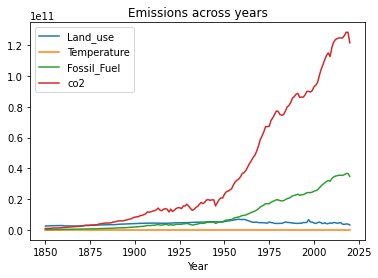

In [29]:
for column in temperature_c02_emissions.columns:
    temperature_c02_emissions[column].plot()
plt.legend(temperature_c02_emissions.columns)
plt.title("Emissions across years")

### Scaling the data

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
temperature_c02_scaled = pd.DataFrame(index=temperature_c02_emissions.index)
temperature_c02_scaled[['Land_use', 'Fossil_Fuel','co2']] = scaler.fit_transform(temperature_c02_emissions[['Land_use', 'Fossil_Fuel','co2']])
temperature_c02_scaled['Temperature'] = temperature_c02_emissions.Temperature
temperature_c02_scaled

,Land_use,Fossil_Fuel,co2,Temperature
Year,,,,
1850,-1.736226,-0.884108,-0.918074,-0.438
1851,-1.660963,-0.883934,-0.918078,-0.324
1852,-1.622715,-0.883137,-0.917085,-0.297
1853,-1.575251,-0.882256,-0.916039,-0.295
1854,-1.548764,-0.878798,-0.911412,-0.293
...,...,...,...,...
2016,-0.602469,2.330056,2.200098,1.059
2017,-0.642038,2.373203,2.240387,0.963
2018,-0.452768,2.438881,2.294502,0.888


Text(0.5, 1.0, 'Scaled Emissions')

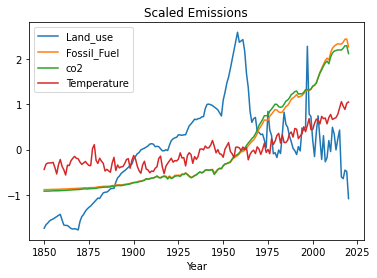

In [31]:
for column in temperature_c02_scaled.columns:
    temperature_c02_scaled[column].plot()
plt.legend(temperature_c02_scaled.columns)
plt.title("Scaled Emissions")

In [32]:
y = temperature_c02_scaled['Temperature']
temperature_c02_scaled.drop(columns=['Temperature'],inplace=True)
temperature_c02_scaled

,Land_use,Fossil_Fuel,co2
Year,,,
1850,-1.736226,-0.884108,-0.918074
1851,-1.660963,-0.883934,-0.918078
1852,-1.622715,-0.883137,-0.917085
1853,-1.575251,-0.882256,-0.916039
1854,-1.548764,-0.878798,-0.911412
...,...,...,...
2016,-0.602469,2.330056,2.200098
2017,-0.642038,2.373203,2.240387
2018,-0.452768,2.438881,2.294502


### Splitting the data using train test split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(temperature_c02_scaled, y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((128, 3), (43, 3), (128,), (43,))

### Initializing and fitting the RF Model

In [34]:
rf_model = RandomForestRegressor()

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor()

### Model score

In [35]:
rf_model.score(X_test, y_test)

0.8919977167731861

In [36]:
y_pred = rf_model.predict(X_test)

Text(0.5, 1.0, 'Prediction')

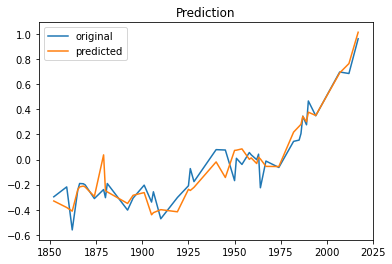

In [37]:
y_pred_df = pd.DataFrame(y_pred, columns=['Temperature'], index=y_test.index)

plt.plot(y_test.sort_index())
plt.plot(y_pred_df.sort_index())
plt.legend(['original','predicted'])
plt.title("Prediction")

In [38]:
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)

SVR()

In [39]:
y_pred = regressor.predict(X_test)
regressor.score(X_test, y_test)

0.8847778995876486

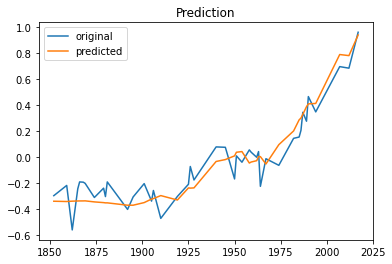

In [40]:
y_pred_df2 = pd.DataFrame(y_pred, columns=['Temperature'], index=y_test.index)
plt.plot(y_test.sort_index())
plt.plot(y_pred_df2.sort_index())
plt.title("Prediction")
plt.legend(['original','predicted'])

# 3. Forecasting Co2 and temperature

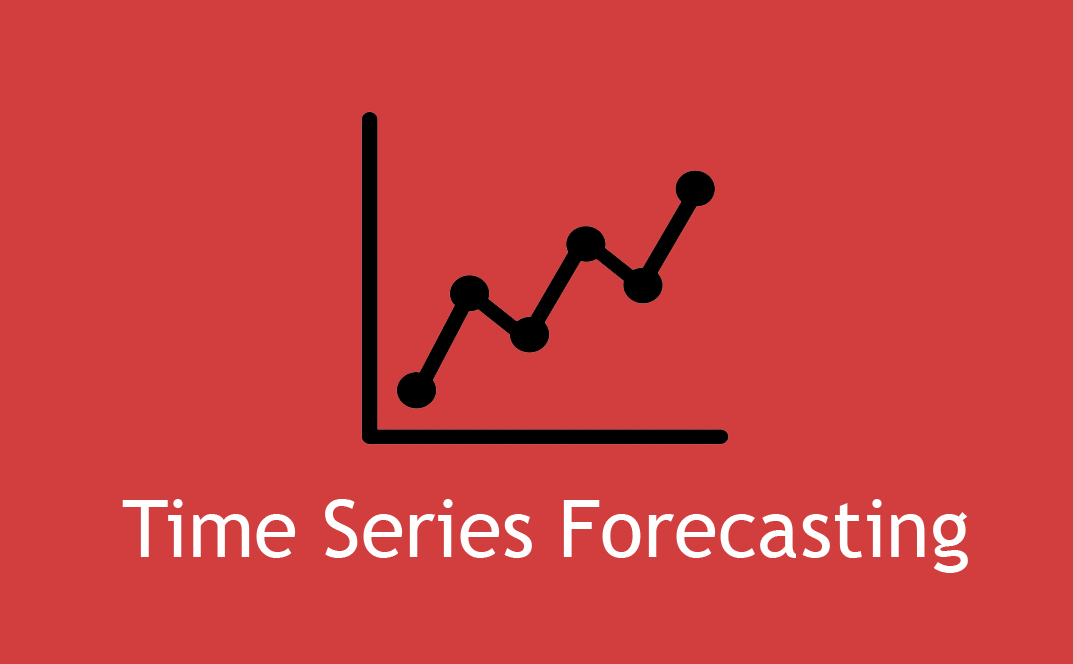

In [41]:
temperature_c02_scaled['Temperature'] = y
temperature_c02_scaled

,Land_use,Fossil_Fuel,co2,Temperature
Year,,,,
1850,-1.736226,-0.884108,-0.918074,-0.438
1851,-1.660963,-0.883934,-0.918078,-0.324
1852,-1.622715,-0.883137,-0.917085,-0.297
1853,-1.575251,-0.882256,-0.916039,-0.295
1854,-1.548764,-0.878798,-0.911412,-0.293
...,...,...,...,...
2016,-0.602469,2.330056,2.200098,1.059
2017,-0.642038,2.373203,2.240387,0.963
2018,-0.452768,2.438881,2.294502,0.888


#### For time series forecasting it is necessary to make the data stationery and just having a look at the plot tells us that data is not stationery.
Stationarity of data can be checked by three parameters :
1. The Mean should be constant
2. The standard deviation should be constant
3. Seasonality should not be present 

If all the three conditions satisfy we can conclude that data is stationery or not

### So to make data stationery one of the way is taking difference

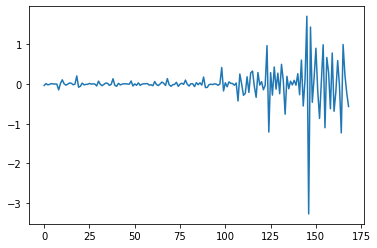

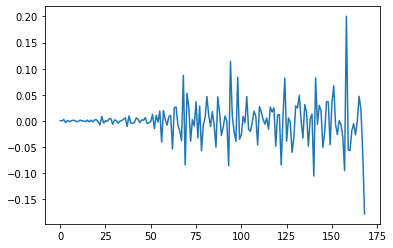

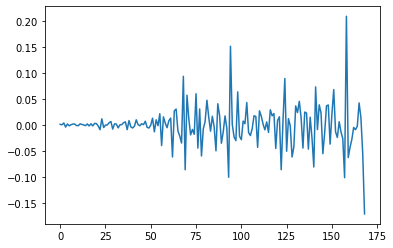

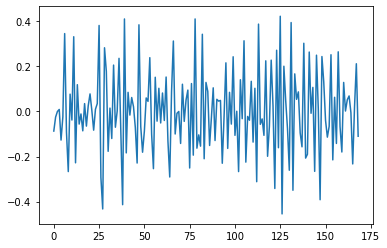

In [42]:
diff = {column:np.diff(temperature_c02_scaled[column]) for column in temperature_c02_scaled.columns}
diff2 = {keys:np.diff(diff[keys]) for keys in diff}
for keys in diff2:
    plt.figure()
    plt.plot(diff2[keys])

### For confirmation we can perform the ADF test to check the stationarity of the data

In [43]:
for keys in diff2: 
    X = diff2[keys]
    print(f"AD fuller test on column {keys} is")
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

AD fuller test on column Land_use is
ADF Statistic: -6.717987
p-value: 0.000000
AD fuller test on column Fossil_Fuel is
ADF Statistic: -4.514305
p-value: 0.000185
AD fuller test on column co2 is
ADF Statistic: -4.939076
p-value: 0.000029
AD fuller test on column Temperature is
ADF Statistic: -7.657263
p-value: 0.000000


In [44]:
df_differenced = temperature_c02_scaled.diff().dropna()
temperature_c02_stat = df_differenced.diff().dropna()
temperature_c02_stat

,Land_use,Fossil_Fuel,co2,Temperature
Year,,,,
1852,-0.037016,0.000623,0.000996,-0.087
1853,0.009216,0.000083,0.000054,-0.025
1854,-0.020977,0.002577,0.003580,0.000
1855,-0.010192,-0.003000,-0.004247,0.009
1856,0.010869,0.001103,0.001684,-0.127
...,...,...,...,...
2016,-1.231477,-0.000539,-0.002734,-0.005
2017,0.994323,0.047154,0.042175,-0.233
2018,0.228839,0.022530,0.013826,0.021


### Implementing ACF & PACF to know how data is correlated

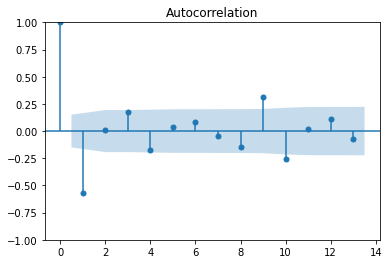

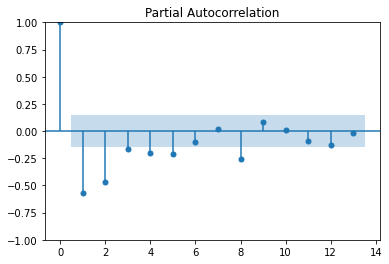

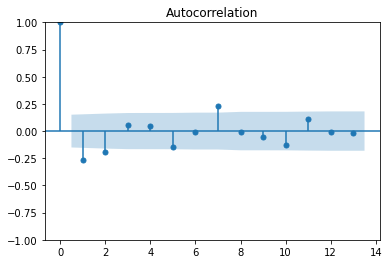

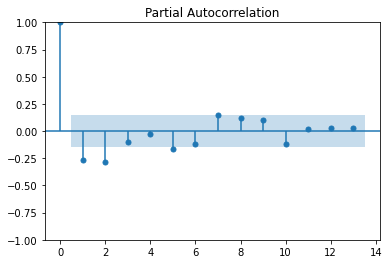

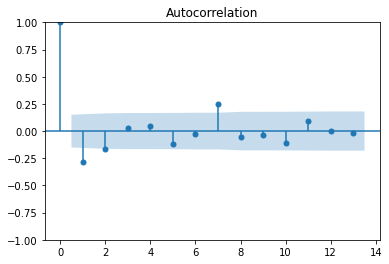

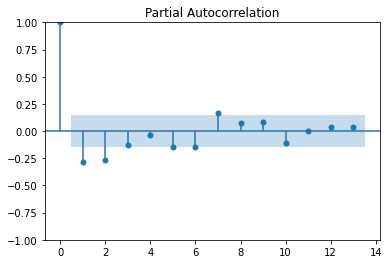

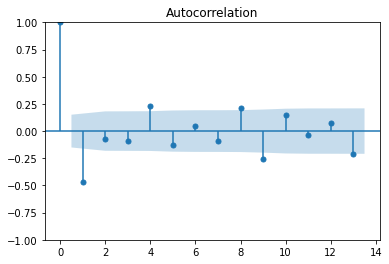

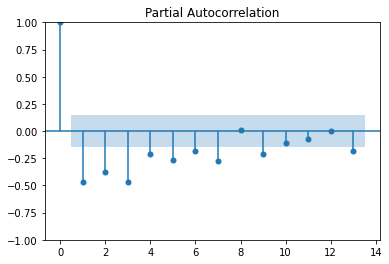

In [45]:
for column in temperature_c02_stat.columns:
    plot_acf(temperature_c02_stat[column],lags = 13)
    plot_pacf(temperature_c02_stat[column],lags = 13,method='ywm')
    plt.show()

In [46]:
#creating the train and validation set
train = temperature_c02_stat[:int(0.9*(len(temperature_c02_stat)))]
valid = temperature_c02_stat[int(0.9*(len(temperature_c02_stat))):]
train.shape,valid.shape

((152, 4), (17, 4))

### Fitting the VAR Model

Vector autoregression (VAR) is a statistical model used to capture the relationship between multiple quantities as they change over time. VAR is a type of stochastic process model. 

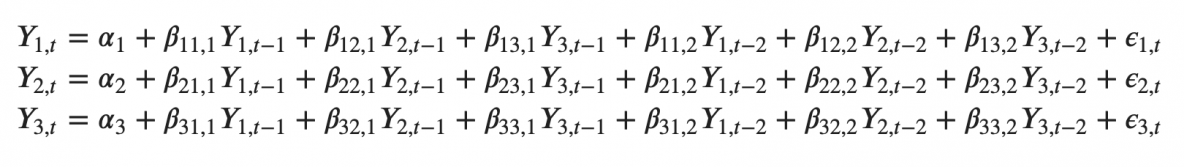

In [47]:
model = VAR(train)
model_fit = model.fit(maxlags=9)
prediction = model_fit.forecast(np.asarray(train), steps=len(valid))

### Forecasting the test dataset

In [48]:
df_forecast = pd.DataFrame(prediction, index=temperature_c02_stat.index[-len(valid):], columns=temperature_c02_stat.columns)
df_forecast

,Land_use,Fossil_Fuel,co2,Temperature
Year,,,,
2004,0.011190,-0.160608,-0.163647,0.102113
2005,0.002610,0.065208,0.054357,-0.016355
2006,-0.176945,0.080950,0.086361,-0.000497
2007,-0.517604,-0.098986,-0.078608,-0.210941
2008,0.573186,0.048533,0.039352,0.276444
2009,-0.305170,0.004215,0.002712,-0.174985
2010,-0.058720,-0.037233,-0.027577,0.116702
2011,0.217831,0.008900,-0.008036,-0.062854
2012,0.044919,0.041410,0.048066,-0.005953


### Forecast vs Actual 

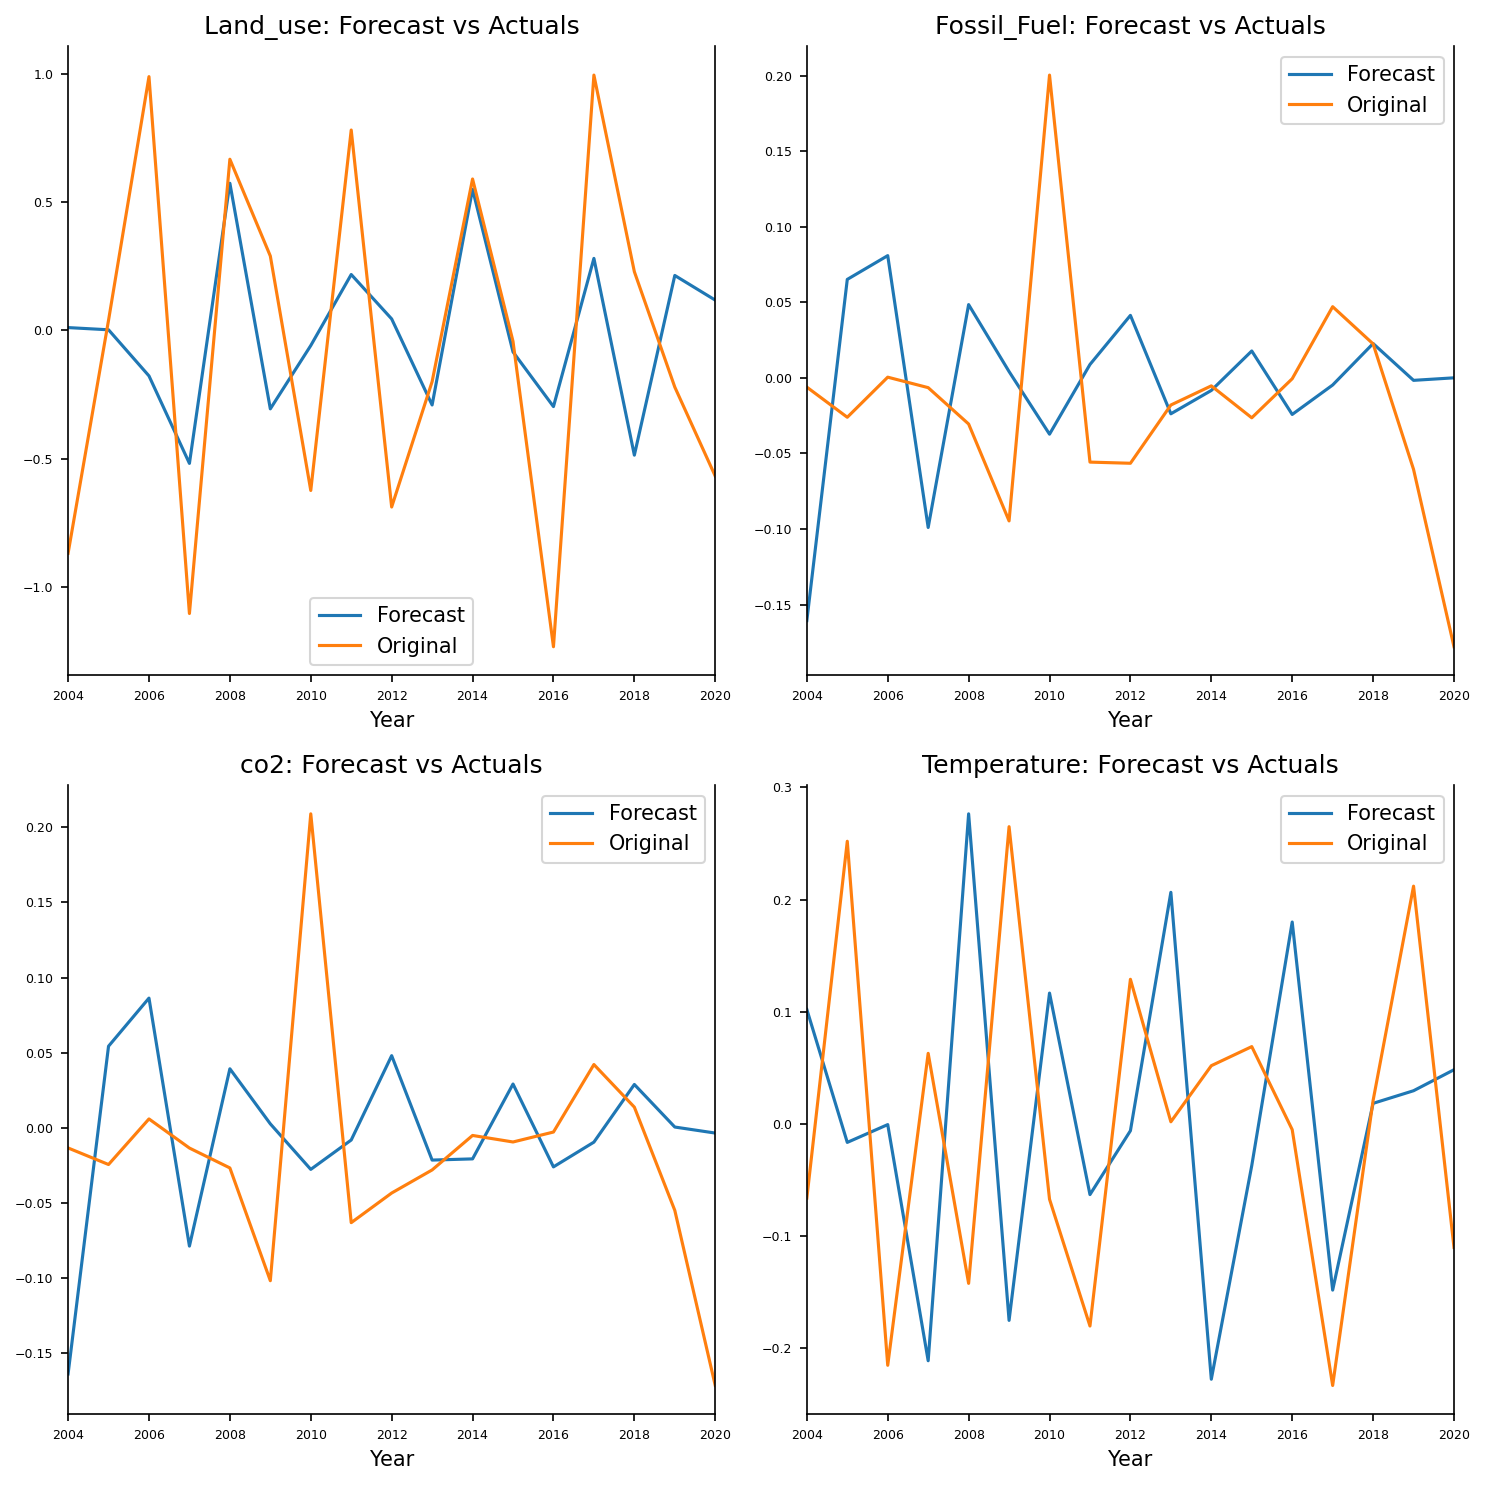

In [49]:
fig, axes = plt.subplots(nrows=int(len(temperature_c02_stat.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(temperature_c02_stat.columns, axes.flatten())):
    df_forecast[col].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    valid[col].plot(ax=ax);
    ax.legend(['Forecast','Original'])
    ax.set_title(col + ": Forecast vs Actuals")
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)
plt.tight_layout();

In [50]:
rows,cols = valid.shape
sum = 0 
for row in range(rows):
    for col in range(cols):
        sum += (valid.iloc[row][col]-prediction[row][col])**2
sum = sum/(rows*cols)
print(f"root mean square error is {sum}")

root mean square error is 0.1145613481425525


### Modeling on the original dataset to predict the future 

In [51]:
model = VAR(temperature_c02_stat)
model_fit = model.fit(9)
yhat = model_fit.forecast(np.asarray(temperature_c02_stat), steps=25)

In [52]:
date_index = pd.date_range('2021', periods=25, freq='Y')
temperature_c02_pred = pd.DataFrame(yhat,index=date_index,columns=temperature_c02_stat.columns)
temperature_c02_pred.index = temperature_c02_pred.index.year
temperature_c02_pred

,Land_use,Fossil_Fuel,co2,Temperature
2021,0.235349,0.128639,0.116943,-0.028782
2022,-0.033200,0.042900,0.046174,-0.021302
2023,0.306013,-0.073159,-0.052969,0.007760
2024,0.251942,0.021327,0.013673,0.039415
2025,-0.540341,0.068648,0.056240,0.052395
2026,-0.267816,-0.034371,-0.028566,-0.050095
2027,0.191165,-0.084886,-0.084251,-0.031556
2028,0.034787,0.031090,0.039122,0.070407
2029,-0.086667,0.028062,0.022230,0.060831
2030,0.330529,-0.021517,-0.024911,-0.242131


## Inverse transforming to get the original data 

In [53]:

df_merged = pd.concat([temperature_c02_stat, temperature_c02_pred], axis=0)
df_differenced[column].iloc[0]

cumsum1 = {column:np.r_[df_differenced[column].iloc[0],df_merged[column]].cumsum() for column in df_merged.columns}
cumsum2 = {keys:np.r_[temperature_c02_scaled[column].iloc[0],cumsum1[keys]].cumsum() for keys in cumsum1}

index = [i for i in temperature_c02_scaled.index]
for i in temperature_c02_pred.index:
    index.append(i)

temperature_c02 = pd.DataFrame(cumsum2,index = pd.to_datetime(index,format='%Y').year )
temperature_c02

,Land_use,Fossil_Fuel,co2,Temperature
1850,-0.438000,-0.438000,-0.438000,-0.438000
1851,-0.362737,-0.437826,-0.438003,-0.324000
1852,-0.324489,-0.437029,-0.437011,-0.297000
1853,-0.277025,-0.436148,-0.435964,-0.295000
1854,-0.250538,-0.432690,-0.431338,-0.293000
...,...,...,...,...
2041,-7.096959,1.601299,1.487697,1.475184
2042,-7.482021,1.512615,1.402976,1.504742
2043,-7.971714,1.437316,1.327506,1.577058
2044,-8.348048,1.375663,1.265964,1.580354


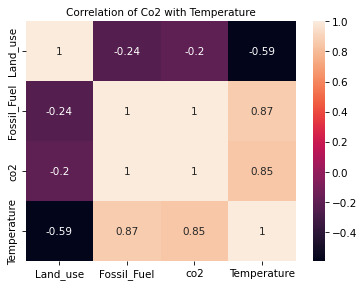

In [54]:
# Plotting the correlation matrix for Emissions vs. Temperature
import seaborn as sns
fig = plt.figure(dpi = 75)
ax = fig.add_axes([0.1, 0.1, 0.75, 0.8]) 
sns.heatmap(temperature_c02.corr(method='pearson'), annot = True)
ax.set_title("Correlation of Co2 with Temperature", fontsize=10)
plt.show()

Text(0.5, 1.0, 'Predicted Emissions')

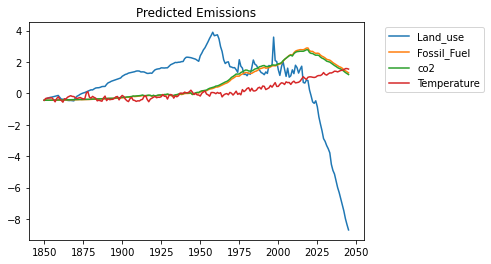

In [55]:
for column in temperature_c02.columns:
    temperature_c02[column].plot()
plt.legend(temperature_c02.columns,bbox_to_anchor=(1.05, 1))
plt.title("Predicted Emissions")

In [56]:
y_test = temperature_c02['Temperature']
y_test =  y_test.loc[2021:]
X_test = temperature_c02.drop(columns = ['Temperature'])
X_test = X_test.loc[2021:]

The below predicted temperature and predictor value will be used
to see how RF model performs on this dataset

In [57]:
y_test,X_test

(2021    1.050218
 2022    1.027134
 2023    1.011809
 2024    1.035899
 2025    1.112385
 2026    1.138775
 2027    1.133609
 2028    1.198850
 2029    1.324922
 2030    1.208864
 2031    1.162531
 2032    1.240424
 2033    1.304044
 2034    1.296430
 2035    1.342307
 2036    1.412261
 2037    1.405300
 2038    1.366295
 2039    1.410222
 2040    1.457814
 2041    1.475184
 2042    1.504742
 2043    1.577058
 2044    1.580354
 2045    1.546616
 Name: Temperature, dtype: float64,
       Land_use  Fossil_Fuel       co2
 2021 -0.147189     2.673197  2.546600
 2022 -0.543419     2.671951  2.537630
 2023 -0.633635     2.597546  2.475693
 2024 -0.471910     2.544469  2.427427
 2025 -0.850525     2.560039  2.435402
 2026 -1.496957     2.541238  2.414811
 2027 -1.952224     2.437552  2.309969
 2028 -2.372704     2.364956  2.244249
 2029 -2.879852     2.320422  2.200758
 2030 -3.056470     2.254371  2.132357
 2031 -3.322980     2.168796  2.050877
 2032 -3.523967     2.140094  2.021381
 2033 -

In [58]:
y_pred_rf = rf_model.predict(X_test)
y_pred_svm = regressor.predict(X_test)
y_pred_rf,y_pred_svm

(array([0.872  , 0.9829 , 0.99117, 0.96582, 1.00174, 1.00174, 0.99763,
        1.02402, 1.02077, 0.8942 , 0.87991, 0.86954, 0.84216, 0.82592,
        0.83955, 0.8371 , 0.80703, 0.78234, 0.77757, 0.77725, 0.74684,
        0.67737, 0.59381, 0.54003, 0.50337]),
 array([0.84885952, 0.92631949, 0.94743064, 0.92428874, 0.97389641,
        0.93856896, 0.81671952, 0.66323523, 0.4864849 , 0.43373425,
        0.36827664, 0.33121413, 0.29607227, 0.24900768, 0.24130059,
        0.23914107, 0.23744148, 0.23699672, 0.23689859, 0.23686549,
        0.23685817, 0.23685688, 0.23685672, 0.23685672, 0.23685672]))

### Here we can see the comparison between the VAR model and RF model

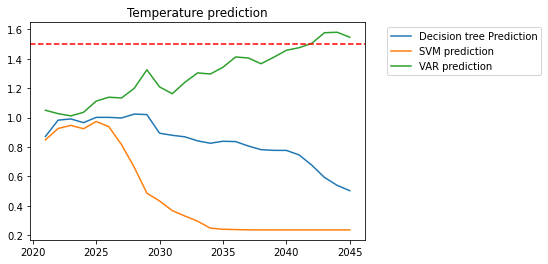

In [59]:
rf_df = pd.DataFrame(y_pred_rf, columns=['Temperature'], index=y_test.index)
svm_df = pd.DataFrame(y_pred_svm, columns=['Temperature'], index=y_test.index)
plt.plot(rf_df.sort_index())
plt.plot(svm_df.sort_index())
plt.plot(temperature_c02['Temperature'].loc[2021:])
plt.axhline(y=1.5, color='r', linestyle='--')
plt.title("Temperature prediction")
plt.legend(['Decision tree Prediction','SVM prediction','VAR prediction'],bbox_to_anchor=(1.05, 1))

## Conclusion

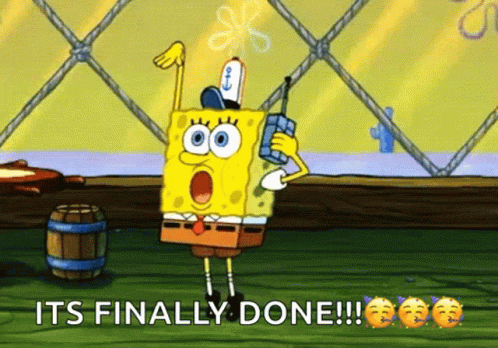

We can see that the Random forest model does not perform well as it shows that temperature decreased drastically in the future
whereas it should have been increased by just looking the data. This is happening as we have predicted the future value of predictor variables using VAR model and hence generating some error.

Whereas we can see that the VAR model and the smoothened model of ARIMA are providing approximately the same results that is the temperature will cross the 1.5$^\circ$C around 2042.